In [20]:
import numpy as np
import scipy.misc
import glob
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from io import BytesIO
from IPython import display
from PIL import Image

def display_image(arr):
    b = BytesIO()
    Image.fromarray(np.uint8(arr)).save(b, format='png')
    data = b.getvalue()
    display.display(display.Image(data=data, format='png', embed=True))

labels = ['gyoku', 'ou', 'kin', 'gin', 'kei', 'kyo', 'kaku', 'hi', 'fu', 'narigin', 'narikei', 'narikyo', 'uma', 'ryu', 'to']
num_classes = len(labels)

# input image dimensions
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 1)

series_imgs = []
series_labels = []
for i, series in enumerate(glob.glob("learn/*.npz")):
    file = np.load(series)
    print(series)
    series_imgs.append(file['imgs'].astype(np.float32))
    series_labels.append(file['labels'])
num_series = len(series_imgs)

learn/21.npz
learn/17.npz
learn/08.npz
learn/09.npz
learn/24.npz
learn/18.npz
learn/06.npz
learn/12.npz
learn/05.npz
learn/16.npz
learn/23.npz
learn/10.npz
learn/01.npz
learn/03.npz
learn/04.npz
learn/14.npz
learn/22.npz
learn/15.npz
learn/20.npz
learn/13.npz
learn/26.npz
learn/25.npz
learn/19.npz
learn/07.npz
learn/11.npz
learn/02.npz
learn/00.npz


In [26]:
# load all
x_all = np.empty((0, img_rows, img_cols))
y_all = np.empty((0, 2), np.int32)
for i in range(num_series):
    num_imgs = len(series_imgs[i])
    x_all = np.r_[x_all, series_imgs[i]]
    label_indices = []
    for j, label in enumerate(series_labels[i]):
        label_indices.append(labels.index(label))
    label_and_series = np.c_[label_indices, np.full((num_imgs), i)]
    y_all = np.r_[y_all, label_and_series]

# reshape to TF
x_all = x_all.reshape(x_all.shape[0], img_rows, img_cols, 1)
x_all = x_all.astype(np.float32)
x_all /= 255

In [27]:
# x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.1)

train_ids = np.where(y_all[:, 1] != 26)
test_ids = np.where(y_all[:, 1] == 26)
x_train = x_all[train_ids]
x_test = x_all[test_ids]
y_train = y_all[train_ids]
y_test = y_all[test_ids]
print(test_ids)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train[:, 0], num_classes)
y_test = keras.utils.to_categorical(y_test[:, 0], num_classes)

datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.25)
datagen.fit(x_train)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

IndexError: too many indices for array

In [28]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), steps_per_epoch=x_train.shape[0],
                    epochs=30, verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
356/356 [==============================] - 8s - loss: 0.0559 - acc: 0.9803 - val_loss: 0.0128 - val_acc: 1.0000
Epoch 2/30
356/356 [==============================] - 8s - loss: 0.0493 - acc: 0.9837 - val_loss: 0.0156 - val_acc: 1.0000
Epoch 3/30
356/356 [==============================] - 8s - loss: 0.0423 - acc: 0.9856 - val_loss: 0.0179 - val_acc: 1.0000
Epoch 4/30
356/356 [==============================] - 8s - loss: 0.0451 - acc: 0.9854 - val_loss: 0.1087 - val_acc: 0.9333ETA: 6s - loss: - ETA: 2s - lo - ETA: 0s - loss: 0.0437 - acc: 
Epoch 5/30
356/356 [==============================] - 8s - loss: 0.0522 - acc: 0.9817 - val_loss: 0.0329 - val_acc: 1.0000
Epoch 6/30
356/356 [==============================] - 8s - loss: 0.0441 - acc: 0.9853 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 7/30
356/356 [==============================] - 8s - loss: 0.0485 - acc: 0.9837 - val_loss: 0.0320 - val_acc: 1.00001s - 
Epoch 8/30
356/356 [==============================] - 8s - loss: 0.0366

In [24]:
pred_res = model.predict(x_test)
res = np.array([np.argmax(r) for r in pred_res])
ans = np.array([np.where(y == 1)[0][0] for y in y_test])
print(res)
print(ans)
correct = np.where(res == ans)[0]
errors = np.where(res != ans)[0]
print(errors)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[]


In [25]:
for e in errors:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    else:
        print("p")
        print(labels[res[e] - len(labels)])

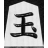

gyoku


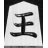

ou


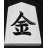

kin


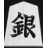

gin


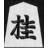

kei


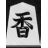

kyo


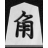

kaku


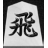

hi


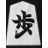

fu


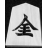

narigin


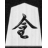

narikei


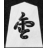

narikyo


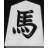

uma


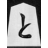

to


In [19]:
for e in correct:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    else:
        print("p")
        print(labels[res[e] - len(labels)])